In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import timeit
import matplotlib as mpl
import random


mpl.rcParams['figure.figsize'] = (10,15)
ds = sio.loadmat('face.mat')

In [2]:
X = ds['X']
l = ds['l'][0]
split = 0.8
W = 46
H = 56
IDs = 52
X = pd.DataFrame(X.transpose())
l = pd.DataFrame(l)

#bagging 
bag_ratio = 0.75
M_pca_ratio = 0.95
M_lda_ratio = 0.1
N = round(X.shape[0]*split) 
N_bag = round(X.shape[0]*split*bag_ratio) #different for each bag now

In [3]:
X_train, X_test, l_train, l_test = train_test_split(X, l, test_size=(1-split), stratify = l)
# X_bar = np.mean(X, axis=1)
X_train, X_test = X_train.values, X_test.values
l_train, l_test = l_train.values, np.transpose(l_test.values)
X_bar = np.transpose([np.mean(X_train, axis=0)])
X_bar = np.ndarray.flatten(X_bar)
print('    l_train.shape',l_train.shape)
print('    X_train.shape', X_train.shape)

    l_train.shape (416, 1)
    X_train.shape (416, 2576)


## Functions to apply 1.3_a to bagging

In [4]:
from random import randrange
#Take the current split data and bag randomly 
def make_bag(X_train_data, l_train_data):
    X_train_part = bag_train_space(X_train_data, l_train_data, 1)
    X_bag_part = []
    l_bag_part = []
#     print(X_train.shape)
#     print(bag, bag_size)
    for i in range(IDs):
#         print('Bullshit ' , len(X_train[i]))
        for j in range(round(len(X_train_part[i])*bag_ratio)):
            index = randrange(len(X_train_part[i]))
#             print(index)
            X_bag_part.append(X_train_part[i][index])
            l_bag_part.append(i+1)
    X_bar_part_bag = np.transpose([np.mean(X_bag_part, axis=0)])
    X_bar_part_bag= np.ndarray.flatten(X_bar_part_bag)
#     print()
    return np.asarray(X_bag_part), np.asarray(l_bag_part), np.asarray(X_bar_part_bag)

In [5]:
def bag_train_space(X_bag_data, l_bag_data, ratio):

    train_subspaces = []
    
    for i in range(IDs):
        images = []
        for j in range(round(N*ratio)):
            if l_bag_data[j] == i+1:
                images.append(X_bag_data[j])
        train_subspaces.append(images)
    return np.asarray(train_subspaces)

In [6]:
def SWSB(bag_subspaces, X_bar_bag):
    elements = np.asarray(bag_subspaces[0])
    elements_mean = np.mean(elements, axis=0)
    elements = np.subtract(elements,elements_mean)
    S_W = np.matmul(elements.T,elements)
    mean_diff = np.atleast_2d(elements_mean)-X_bar_bag
#     print(mean_diff.shape)
    S_B = np.matmul(mean_diff.T, mean_diff)
    for i in range(1,IDs):
#         print(i)
        elements = np.asarray(bag_subspaces[i])
#         print(train_subspaces.shape)
        elements_mean = np.mean(elements, axis=0)
        elements = np.subtract(elements,elements_mean)
        S_W += np.matmul(elements.T,elements)
        mean_diff = np.atleast_2d(elements_mean)-X_bar_bag
        S_B += np.matmul(mean_diff.T, mean_diff)
    
    return S_W, S_B
                   

In [7]:
#PCA
def PCA(X_train_pca, X_bar_pca):
    A = np.subtract(X_train_pca,X_bar_pca).T
#     print(A.shape)
#     print(np.matmul(A.T,A).shape)
    w_pca, v_pca = np.linalg.eigh((1/N)*np.matmul(A.T,A))
    inds = w_pca.argsort()[::-1]

    w_pca = w_pca[inds]
    v_pca = v_pca[:,inds]
    cum_w = np.cumsum(w_pca)/np.sum(w_pca);
    M_pca = np.argmax(cum_w>M_pca_ratio)
                
    print('    M PCA',M_pca)
    
    w_pca = w_pca[:M_pca]
    v_pca = v_pca[:,:M_pca]
    v_pca = preprocessing.normalize(np.matmul(A,v_pca), axis=0)
    
    print('    v_pca.shape', v_pca.shape)
    
    return w_pca, v_pca

In [75]:
#PCA
def rand_PCA(X_train_pca, X_bar_pca):
    A = np.subtract(X_train_pca,X_bar_pca).T
#     print(A.shape)
#     print(np.matmul(A.T,A).shape)
    w_pca, v_pca = np.linalg.eig((1/N)*np.matmul(A.T,A))
    inds = w_pca.argsort()[::-1]
    
    w_pca = w_pca[inds]
    v_pca = v_pca[:,inds]
#     cum_w = np.cumsum(w_pca)/np.sum(w_pca);
    M_0 = 60   #np.argmax(cum_w>M_pca_ratio)
    M_1 = 40
    
    mask = []
    
    for p in range(0,M_1):
        x = random.randint(M_0,415)
        while x in mask:
            x = random.randint(M_0,415)
        mask.append(x)
        
#     print('    ', v_pca.shape)
    
    w_pca_0 = w_pca[:M_0]
    v_pca_0 = v_pca[:,:M_0]
#     print('    v_pca_0.shape', v_pca_0.shape )
#     w_pca_rand = w_pca[M_0:]
#     v_pca_rand = v_pca[:,M_0:]
    
    w_pca_1 = w_pca[mask]
    v_pca_1 = v_pca[:,mask]
#     print('    v_pca_rand.shape', v_pca_rand.shape)
# #     #----------random feature space-----#
#     w_pca_1, x, v_pca_1, y = train_test_split(w_pca_rand, v_pca_rand, test_size=(M_1/v_pca_rand.shape[1]))
#     print('    v_pca_1.shape', v_pca_1.shape)
#     #-----------------------------------#
# #     w_mask = np.random.choice(M_0, M_1, replace=false)
# #     v_mask = np.random.choice(np.arange(M_0, 416),  M_1, replace=False)
# #     print(mask1)
    
    v_pca_full = np.append(v_pca_0.T, v_pca_1.T, axis=0)
#     w_pca_full = w_pca[v_mask[1]]
#     v_pca_full = v_pca[v_mask]
#     print('    v_pca_full', v_pca_full.shape)
    
    v_pca_full = preprocessing.normalize(np.matmul(A,v_pca_full.T), axis=0)
    w_pca_full = np.append(w_pca_0, w_pca_1)
    
#     print('    v_pca_full', v_pca_full.shape)
#     print('    A.shape', A.shape)
    
    return w_pca_full, v_pca_full

In [36]:
#LDA
def LDA(S_W_bag, S_B_bag, v_pca):
    proj_1 = np.dot(np.dot(v_pca.T,S_W_bag),v_pca)
    proj_2 = np.dot(np.dot(v_pca.T,S_B_bag),v_pca)

    w_fld, v_fld = np.linalg.eig(np.linalg.inv(proj_1).dot(proj_2))
    
    cum_w = np.cumsum(w_fld)/np.sum(w_fld);
    M_lda = 35
#     print('    M LDA', M_lda)
    
    inds = w_fld.argsort()[::-1]
    w_fld = w_fld[inds]
#     print(w_fld.shape)
    v_fld = v_fld[:,inds]

    
    w_fld = w_fld[:M_lda]
    v_fld = v_fld[:,:M_lda]
    return w_fld, v_fld
    
    

In [79]:

#LDA

def LDA_prob(S_W_bag, S_B_bag, v_pca):
    proj_1 = np.dot(np.dot(v_pca.T,S_W_bag),v_pca)
    proj_2 = np.dot(np.dot(v_pca.T,S_B_bag),v_pca)

    w_fld, v_fld = np.linalg.eig(np.linalg.inv(proj_1).dot(proj_2))
    
    cum_w = np.cumsum(w_fld)/np.sum(w_fld);
    M_lda = 40
    print('    M LDA', M_lda)
    
    inds = w_fld.argsort()[::-1]
    w_fld = w_fld[inds]
#     print(w_fld.shape)
    v_fld = v_fld[:,inds]

    
    w_fld = w_fld[:M_lda]
    v_fld = v_fld[:,:M_lda]
    
    #---------- Predict ---------- # 
    
    
    
    return w_fld, v_fld
    

ImportError: cannot import name 'predict_proba' from 'sklearn' (c:\users\jack\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\__init__.py)

In [38]:
#W_OPT
def w_opt(v_pca, v_fld): 
    v_opt = np.dot(v_pca,v_fld)
    v_opt = preprocessing.normalize(np.real(v_opt),axis=0)
    return v_opt

In [39]:
#Get error of each bag
def error(v_opt, X_train_dataset, X_test_data, l_train_error, l_test_error):
    Y_train = []
    for i in range(int(N_bag)):
        Y_train.append(np.matmul(v_opt.T,X_train_dataset[i]))
        
    correct = 0
    l_pred = []
    
    for i in range(len(X_test)):
        y_test = np.matmul(v_opt.T, X_test_data[i])
        diff = np.subtract(Y_train, y_test)
        pred = np.diag(np.matmul(diff, diff.T))
        value = np.argmin(pred)
        l_pred.append(l_train_error[value])
        if l_train_error[value] == l_test_error[0][i]:
            correct += 1
            
    return correct/len(l_test[0]), l_pred

In [162]:

from sklearn.neighbors import KNeighborsClassifier
def prob_pred(v_opt, X_train, l_train):
    Y_train = []
    for i in range(len(l_train)):
        Y_train.append(np.matmul(v_opt.T,X_train[i]))

    neigh = KNeighborsClassifier(n_neighbors=1)  
    neigh.fit(Y_train, l_train)
    
    preds = []
    Y_test = []
    inds = l_train.T[0].argsort()
    
    for i in range(len(l_test[0])):
        lil_test = np.matmul(v_opt.T,X_test[i])
        Y_test.append(lil_test)
        diff = np.subtract(Y_train, lil_test)
        pred = np.reciprocal(np.amin(np.diag(np.matmul(diff, diff.T))[inds].reshape(-1,8),axis = 1))
        pred = pred/np.sum(pred)
        
        preds.append(pred)
        
    return preds

In [163]:

model_space = bag_train_space(X_train, l_train, 1)
#     print('    ', model_space.shape)
S_W, S_B = SWSB(model_space, X_bar)
print('    Model:', i+1)
w_pca, v_pca = rand_PCA(X_train, X_bar)
#         plt.plot(w_pca)
w_fld, v_fld = LDA(S_W, S_B, v_pca)
v_opt = w_opt(v_pca, v_fld)
probb = prob_pred(v_opt, X_train, l_train)
# err, l_pred = error(v_opt, X_train, X_test, l_train, l_test)
# print(probb)


    Model: 1


c:\users\jack\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':


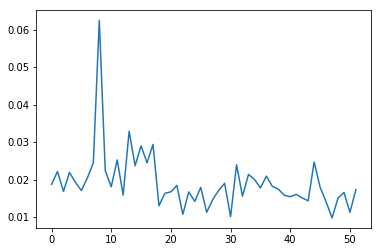

In [164]:
plt.plot(probb[3])

In [165]:
np.sum(probb[3])

1.0

In [155]:
np.argmin(probb[3]) +1

9

In [153]:
l_test[0][3]

9

#### Calling Functions 
***For loop***
- make bags
- make training subspaces
- make eigen subspaces & S_W & S_B 
- PCA 
- LDA 
- W_opt 
- Error calculation
- Committie machine


In [40]:
# TEST SCRIPT
X_bag_0, l_bag_0, X_bar_0 = make_bag(X_train, l_train)

print('    X bag shape', X_bag_0.shape,'l bag shape', l_bag_0.shape, 'X bar bag', X_bar_0.shape)

bag_0_train_space = bag_train_space(X_bag_0, l_bag_0, bag_ratio)

print('    bag train space shape:', bag_0_train_space.shape)

S_W_0, S_B_0= SWSB(bag_0_train_space, X_bar_0)

print('    S_W', S_W_0.shape, 'S_B', S_B_0.shape)

    X bag shape (312, 2576) l bag shape (312,) X bar bag (2576,)
    bag train space shape: (52, 6, 2576)
    S_W (2576, 2576) S_B (2576, 2576)


In [41]:
print(l_bag_0.shape)

(312,)


In [55]:
def N_bag_error(No_bags, X_train, l_train):
    bag_error = []
    bag_pred = []
    for i in range(No_bags):
        print('    Bag:', i+1)
        X_bag, l_bag, X_bar_bag = make_bag(X_train, l_train)
        bag_space = bag_train_space(X_bag, l_bag, bag_ratio)
        print('    ',bag_space.shape)
#         print(X_bar_bag.shape)
        S_W, S_B = SWSB(bag_space, X_bar_bag)
        w_pca, v_pca = PCA(X_bag, X_bar_bag)
        w_fld, v_fld = LDA(S_W, S_B, v_pca)
        v_opt = w_opt(v_pca, v_fld)
        err, l_pred = error(v_opt, X_bag, X_test, l_bag, l_test)
        print('    ', err)
        bag_error.append(err)
        bag_pred.append(l_pred)
        
        
    return bag_error, bag_pred      

In [65]:
def N_space_error(No_models, X_train, l_train):
    model_error = []
    model_pred = []
    
    model_space = bag_train_space(X_train, l_train, 1)
#     print('    ', model_space.shape)
    S_W, S_B = SWSB(model_space, X_bar)
    for i in range(No_models):
        print('    Model:', i+1)
        w_pca, v_pca = rand_PCA(X_train, X_bar)
#         plt.plot(w_pca)
        w_fld, v_fld = LDA(S_W, S_B, v_pca)
        v_opt = w_opt(v_pca, v_fld)
        err, l_pred = error(v_opt, X_train, X_test, l_train, l_test)
        print('    ', err)
        model_error.append(err)
        model_pred.append(l_pred)
        
        
    return model_error, model_pred 

In [74]:
models_error, models_pred = N_space_error(20, X_train, l_train)

    Model: 1
     (416, 416)
     0.8173076923076923
    Model: 2
     (416, 416)
     0.7596153846153846
    Model: 3
     (416, 416)
     0.7884615384615384
    Model: 4
     (416, 416)
     0.7980769230769231
    Model: 5
     (416, 416)
     0.8365384615384616
    Model: 6
     (416, 416)
     0.8365384615384616
    Model: 7
     (416, 416)
     0.7980769230769231
    Model: 8
     (416, 416)
     0.7788461538461539
    Model: 9
     (416, 416)
     0.8173076923076923
    Model: 10
     (416, 416)
     0.7692307692307693
    Model: 11
     (416, 416)
     0.75
    Model: 12
     (416, 416)
     0.75
    Model: 13
     (416, 416)
     0.8076923076923077
    Model: 14
     (416, 416)
     0.7980769230769231
    Model: 15
     (416, 416)
     0.8076923076923077
    Model: 16
     (416, 416)
     0.7788461538461539
    Model: 17
     (416, 416)
     0.7788461538461539
    Model: 18
     (416, 416)
     0.8269230769230769
    Model: 19
     (416, 416)
     0.7980769230769231
    Model: 

In [56]:
bags_error, bags_pred = N_bag_error(10, X_train, l_train)

    Bag: 1
     (52, 6, 2576)
    M PCA 86
    v_pca.shape (2576, 86)
     0.7403846153846154
    Bag: 2
     (52, 6, 2576)
    M PCA 84
    v_pca.shape (2576, 84)
     0.6730769230769231
    Bag: 3
     (52, 6, 2576)
    M PCA 87
    v_pca.shape (2576, 87)
     0.7211538461538461
    Bag: 4
     (52, 6, 2576)
    M PCA 86
    v_pca.shape (2576, 86)
     0.6923076923076923
    Bag: 5
     (52, 6, 2576)
    M PCA 85
    v_pca.shape (2576, 85)
     0.6057692307692307
    Bag: 6
     (52, 6, 2576)
    M PCA 86
    v_pca.shape (2576, 86)
     0.6730769230769231
    Bag: 7
     (52, 6, 2576)
    M PCA 86
    v_pca.shape (2576, 86)
     0.6826923076923077
    Bag: 8
     (52, 6, 2576)
    M PCA 83
    v_pca.shape (2576, 83)
     0.6730769230769231
    Bag: 9
     (52, 6, 2576)
    M PCA 82
    v_pca.shape (2576, 82)
     0.6538461538461539
    Bag: 10
     (52, 6, 2576)
    M PCA 85
    v_pca.shape (2576, 85)
     0.7211538461538461


In [16]:
def commit_cor(bags_pred, l_test):
    correct = 0
    for i in range(len(bags_pred)):
#     for i in range(bags_pred.shape[0]):
#         value = np.floor(np.argmin(bags_pred[i])/round(8*bag_ratio))+1
# #         print(value, l_test[0][i])
        if bags_pred[i] == l_test[0][i]:
            correct += 1
    return correct/104

In [17]:
def commit_mac(bags_pred, bags_err):
    
    y_pred = []
    for i in range(bags_pred.T.shape[0]):
        im_pred = np.zeros(IDs)
        for j in range(bags_pred.T.shape[1]):
            im_pred[bags_pred.T[i][j]-1] += 1
        y_pred.append(np.argmax(im_pred)+1)
    return y_pred
    

In [105]:
bags_pred = np.asarray(bags_pred)
print('    ', bags_pred.shape)
print('    ', bags_pred[0])

     (20, 104)
     [38  2 14  4 34 28 37 22 36 30 28 40 12 32  8 46 23 42 30  7 38 29  2 32
 30  5 17 25 29 50 15 38 18 33 29  4 38  6 35 29 34  8  5 51  8 35 29 41
 50 48 21 19 16 11  8 30 42 30 48 35 30 26 48 18 37  6 16 18 25  3 42  8
 21 13 41 29 15  5  7 21 51 31 13 33 31  7 52 39 23  6 39 48 28 10  1 42
 47 48  3 20  6 51  6 49]


In [66]:
bags_commit = commit_mac(bags_pred, bags_error)

In [67]:
print('    ', commit_cor(bags_commit, l_test))

     0.8173076923076923


In [76]:
models_pred = np.asarray(models_pred)
models_pred = np.squeeze(models_pred, axis=2)
print('    ', models_pred.shape)

# print('    ', models_pred[0])

     (20, 104)


In [77]:
models_commit = commit_mac(models_pred, models_error)

In [78]:
print('    ', commit_cor(models_commit, l_test))

     0.8653846153846154


In [ ]:
from tqdm import tqdm
M_0_max = 150
M_1_max = 150 
for i in tqdm(range(1,M_0_max)):
    for j in tqdm(range(1,M_1_max)):
        for k in tqdm(range(30,50)):
            M_lda = k
            M_0 = i 
            M_1 = j
            models_error, models_pred = N_space_error(30, X_train, l_train)
            models_pred = np.asarray(models_pred)
            models_pred = np.squeeze(models_pred, axis=2)
            models_commit = commit_mac(models_pred, models_error)
            print('    ', commit_cor(models_commit, l_test), M_0, M_1, M_lda)

  0%|                                                                                          | 0/149 [00:00<?, ?it/s]

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

     0.009615384615384616 1 1 30




  5%|████▏                                                                              | 1/20 [00:28<09:06, 28.74s/it]

     0.028846153846153848 1 1 31




 10%|████████▎                                                                          | 2/20 [00:40<07:04, 23.60s/it]

     0.019230769230769232 1 1 32




 15%|████████████▍                                                                      | 3/20 [00:51<05:39, 19.98s/it]

     0.0 1 1 33




 20%|████████████████▌                                                                  | 4/20 [01:03<04:38, 17.42s/it]

In [48]:
print('    ', X_bar.shape)

     (2576,)
